# HW05: Practice with algorithm selection, grid search, cross validation, multiclass classification, one-class classification, imbalanced data, and model selection.

[Ramona Liu kliu268]

##### Hello Students:
 Start by downloading HW05.ipynb from this folder. Then develop it into your solution.
- Write code where you see "... your code here ..." below.
  (You are welcome to use more than one cell.)
- If you have questions, please ask them in class, office hours, or piazza. Our TA
  and I are very happy to help with the programming (provided you start early
  enough, and provided we are not helping so much that we undermine your learning).
- When you are done, run these Notebook commands:
  - Shift-L (once, so that line numbers are visible)
  - Kernel > Restart and Run All (run all cells from scratch)
  - Esc S (save)
  - File > Download as > HTML
- Turn in:
  - HW03.ipynb to Canvas's HW03.ipynb assignment
  - HW03.html to Canvas's HW03.html assignment
  - As a check, download your files from Canvas to a new 'junk' folder. Try 'Kernel > Restart
  and Run All' on the '.ipynb' file to make sure it works. Glance through the '.html' file.
- Turn in partial solutions to Canvas before the deadline. e.g. Turn in part 1,
  then parts 1 and 2, then your whole solution. That way we can award partial credit
  even if you miss the deadline. We will grade your last submission before the deadline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

from sklearn.gaussian_process.kernels import ConstantKernel

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler

## 1. Algorithm selection for multiclass classification by optical recognition of handwritten digits

The [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) dataset
  has 1797 labeled images of hand-written digits.
  - $X$ = `digits.data` has shape (1797, 64).
    - Each image $\mathbf{x}_i$ is represented as the $i$th row of 64 pixel values in the 2D
      `digits.data` array that corresponds to an 8x8 photo of a handwritten digit.
  - $y$ = `digits.target` has shape (1797,). Each $y_i$ is a number from 0 to 9 indicating
    the handwritten digit that was photographed and stored in $\mathbf{x}_i$.



### 1(a) Load the digits dataset and split it into training, validation, and test sets as I did in the lecture example code [07ensemble.html](https://pages.stat.wisc.edu/~jgillett/451/burkov/07/07ensemble.html).
This step does not need to display any output.

In [2]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
# split 80% training data, 20% "_tmp" for validation & test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2,
                                                  random_state=0, stratify=y)
# of remaining 20%, split in half to get 10% validation, 10% test
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,
  random_state=0, stratify=y_tmp)

## 1(b) Use algorithm selection on training and validation data to choose a best classifier.
Loop through these four classifiers and corresponding parameters, doing a grid search
to find the best hyperparameter setting. Use only the training data for the grid search.
- SVM:
  - Try all values of `kernel` in 'linear', 'rbf'.
  - Try all values of `C` in 0.01, 1, 100.
- logistic regression:
  - Use `max_iter=5000` to avoid a nonconvergence warning.
  - Try all values of `C` in 0.01, 1, 100.
- ID3 decision tree:
  - Use `criterion='entropy` to get our ID3 tree.
  - Try all values of `max_depth` in 1, 3, 5, 7.
- kNN:
  - (Use the default Euclidean distance).
  - Try all values of `n_neighbors` in 1, 2, 3, 4.

Hint:
- Make a list of the four classifiers without setting any hyperparameters.
- Make a list of four corresponding parameter dictionaries.
- Loop through 0, 1, 2, 3:
  - Run grid search on the $i$th classifier with the $i$th parameter dictionary on the
    training data. (The grid search does its own cross-validation using the training data.)
  - Use the $i$th classifier with its best hyperparameter settings (just `clf` from
    `clf = GridSearchCV(...)`) to find the accuracy of the model on the validation data, i.e.
    find `clf.score(X_valid, y_valid)`.
- Keep track, as your loop progresses, of:
  - the index $i$ of the best classifier (initialize it to `-1` or some other value)
  - the best accuracy score on validation data (initialize it to `-np.Inf`)
  - the best classifier with its hyperparameter settings, that is the best `clf` from
    `clf = GridSearchCV(...)` (initialize it to `None` or some other value)

I needed about 30 lines of code to do this. It took a minute to run.

In [3]:
classifiers = ['SVM', 'logistic_regression','ID3_decision_tree','kNN']
estimators = [
        (svm.SVC()),
        (linear_model.LogisticRegression()),
        (DecisionTreeClassifier()),
        (KNeighborsClassifier())
    ]
params = [
    {'kernel': ['linear','rbf'],'C': [0.01, 1, 100]},
    {'max_iter' : [5000],'C' : [0.01, 1, 100]},
    {'criterion' : ['entropy'],'max_depth' : [1,3,5,7]},
    {'n_neighbors':[1,2,3,4]}
]


#Initialize the best accuracy score on validation data 
best_accuracy_score = np.array([-np.inf,-np.inf,-np.inf,-np.inf])
#Initialize the best classifier with its hyperparameter settings to None
best_hyperparameter = np.array([None,None,None,None])

max_accuracy_score = 0
index_of_best_classifier = -1
for i in np.arange(4):
    clf = GridSearchCV(estimator=estimators[i], param_grid=params[i])
    #print(clf)
    clf.fit(X_train, y_train)
    print(f'When the classifier is {classifiers[i]},the best accuracy score on validation data is {clf.score(X_valid,y_valid):.3},the best hyperparameters are {clf.best_params_}')
    best_accuracy_score[i] = clf.score(X_valid, y_valid)
    best_hyperparameter[i] = clf.best_params_
    if best_accuracy_score[i] > max_accuracy_score:
        max_accuracy_score = best_accuracy_score[i]
        index_of_best_classifier = i
print(f'The best classifier is {classifiers[index_of_best_classifier]} with the best hyperparameters {best_hyperparameter[index_of_best_classifier]}, and the best validation accuracy score is {best_accuracy_score[index_of_best_classifier]:.3}')

When the classifier is SVM,the best accuracy score on validation data is 0.989,the best hyperparameters are {'C': 1, 'kernel': 'rbf'}
When the classifier is logistic_regression,the best accuracy score on validation data is 0.972,the best hyperparameters are {'C': 0.01, 'max_iter': 5000}
When the classifier is ID3_decision_tree,the best accuracy score on validation data is 0.833,the best hyperparameters are {'criterion': 'entropy', 'max_depth': 7}
When the classifier is kNN,the best accuracy score on validation data is 0.989,the best hyperparameters are {'n_neighbors': 3}
The best classifier is SVM with the best hyperparameters {'C': 1, 'kernel': 'rbf'}, and the best validation accuracy score is 0.989


### 1(c) Use the test data to evaluate your best classifier and its hyperparameter settings from 1(b).
- Report the result of calling `.score(X_test, y_test)` on your best classifier/hyperparameters.
- Make a confusion matrix from the true `y_test` values and the corresponding $\hat{y}$ values
  predicted by your best classifier/hyperparameters on `X_test`.
- For each of the wrong predictions (where `y_test` and your $\hat{y}$ values disagree), show:
  - The index $i$ in the test data of that example $\mathbf{x}$
  - The correct label $y_i$
  - Your incorrect prediction $\hat{y}_i$
  - A plot of that image

In [4]:
clf = svm.SVC(C=1, kernel= 'rbf')
clf.fit(X_train, y_train)
round(clf.score(X_test,y_test),3)

0.978

In [5]:
y_pred = clf.predict(X_test)
M = confusion_matrix(y_test, y_pred)
M

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 18,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 18,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 18,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 17]])

In [6]:
idx_wrong_pred = np.where(y_test != y_pred)
idx_wrong_pred[0][1]

65

(array([ 61,  65, 152, 177]),)
The index of the wrong predicted value is 61,    the correct label is 9, the wrong prediction is 5
The index of the wrong predicted value is 65,    the correct label is 4, the wrong prediction is 8
The index of the wrong predicted value is 152,    the correct label is 8, the wrong prediction is 1
The index of the wrong predicted value is 177,    the correct label is 3, the wrong prediction is 7


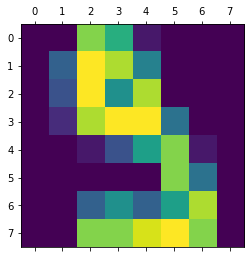

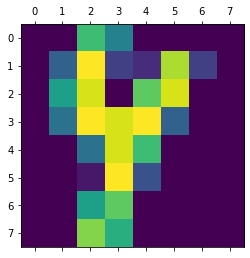

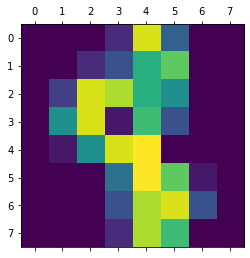

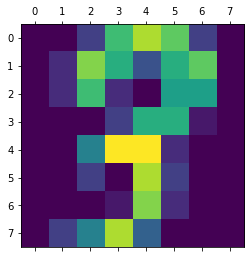

In [7]:
idx_wrong_pred = np.where(y_test != y_pred)
print(idx_wrong_pred)
indices = []
for idx in idx_wrong_pred[0]:
    print(f'The index of the wrong predicted value is {idx},\
    the correct label is {y_test[idx]}, the wrong prediction is {y_pred[idx]}')
    plt.matshow(X_test[idx].reshape(8,8))

## 2. One-class classification (outlier detection)

### 2(a) There is an old gradebook of mine at [http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt](http://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt).
Use `pd.read_table()` to read it into a DataFrame.

Hint: `pd.read_table()` has many parameters. Check its documentation to find three parameters to:
- Read from the given URL
- Use the separator '\s+', which means 'one or more whitespace characters'
- Skip the first 12 rows, as they are a note to students and not part of the gradebook

In [8]:
df = pd.read_table(filepath_or_buffer='https://pages.stat.wisc.edu/~jgillett/451/data/midtermGrades.txt',
                   sep='\s+', skiprows=12)
df

,Exam1,Exam2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,HW6,HW7,HW8,HW9,Percentage,Rank,Percentile,percentageGrade,percentileGrade,Grade
0,121,120,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,3.0,4.0,97.13,391,99.7,A,A,A
1,119,116,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,3.5,4.0,3.5,95.22,390,99.5,A,A,A
2,125,109,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.0,4.0,4.0,2.5,94.90,389,99.2,A,A,A
3,117,115,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,3.5,4.0,94.27,387,98.7,A,A,A
4,110,122,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,4.0,4.0,4.0,4.0,94.27,387,98.7,A,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,94,0,4,4.0,4.0,3.64,2.4,4,4.0,4.00,...,4.0,3.0,2.5,3.0,49.09,5,1.0,F,F,F
387,0,84,4,4.0,3.7,4.00,0.0,0,4.0,4.00,...,4.0,4.0,4.0,3.0,45.91,4,0.8,F,F,F
388,0,82,4,4.0,4.0,4.00,4.0,4,4.0,4.00,...,3.5,4.0,0.0,4.0,44.75,3,0.5,F,F,F
389,84,0,4,4.0,1.0,2.12,3.2,0,0.5,1.38,...,0.0,0.0,0.0,0.0,36.21,2,0.3,F,F,F


### 2(b) Use `clf = mixture.GaussianMixture(n_components=1)` to make a one-class Gaussian model to decide which $\mathbf{x}=(\text{Exam1}, \text{Exam2})$ are outliers:

- Set a matrix X to the first two columns, Exam1 and Exam.
- These exams were worth 125 points each. Transform scores to percentages in $[0, 100]$.

  Hint: I tried the MinMaxScaler() first, but it does the wrong thing if there aren't scores
  of 0 and 125 in each column. So I just multiplied the whole matrix by 100 / 125.
- Fit your classifier to X.
  
  Hint:
  - The reference page for `mixture.GaussianMixture` includes a `fit(X, y=None)` method
    with the comment that y is ignored (as this is an unsupervised learning algorithm--there
    is no $y$) but present for API consistency. So we can fit with just X.
  - I got a warning about "KMeans ... memory leak". You may ignore this
    warning if you see it. I still got satisfactory results.
- Print the center $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$ from the two-variable
  $N_2(\mathbf{\mu}, \mathbf{\Sigma})$ distribution you estimated.

In [9]:
X = df[['Exam1','Exam2']].to_numpy()
X = X*(100/125)
clf = mixture.GaussianMixture(n_components=1)
clf.fit(X)
print(f'The center 𝜇 is {clf.means_},'
      f'\nThe covariance 𝚺 is {clf.covariances_}.')

The center 𝜇 is [[82.81329923 71.01176471]],
The covariance 𝚺 is [[[155.51123078  73.02961336]
  [ 73.02961336 180.87014392]]].


### 2(c) Here I have given you code to make a contour plot of the negative log likelihood $-\ln f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ for $\mathbf{X} \sim N_2(\mathbf{\mu}, \mathbf{\Sigma})$, provided you have set `clf`.

```
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
```

Paste my code into your code cell below and add more code:
- Add black $x$- and $y$- axes. Label them Exam1 and Exam2.
- Plot the data points in blue.
- Plot $\mathbf{\mu}=$ `clf.means_` as a big lime dot.
- Overplot (i.e. plot again) in red the 8 outliers determined by a threshold consisting
  of the 0.02 quantile of the pdf values $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$
  for each $\mathbf{x}$ in X.
  
  Hint: `clf.score_samples(X)` gives log likelihood, so `np.exp(clf.score_samples(X))`
  gives the required $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ values.

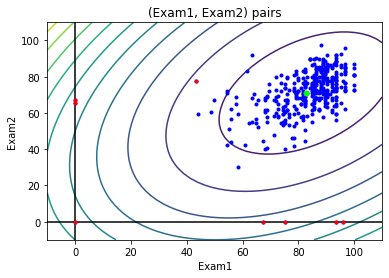

In [10]:
# make contour plot of log-likelihood of samples from clf.score_samples()
margin = 10
x = np.linspace(0 - margin, 100 + margin)
y = np.linspace(0 - margin, 100 + margin)
grid_x, grid_y = np.meshgrid(x, y)
two_column_grid_x_grid_y = np.array([grid_x.ravel(), grid_y.ravel()]).T
negative_log_pdf_values = -clf.score_samples(two_column_grid_x_grid_y)
grid_z = negative_log_pdf_values
grid_z = grid_z.reshape(grid_x.shape)
plt.contour(grid_x, grid_y, grid_z, levels=10) # X, Y, Z
plt.title('(Exam1, Exam2) pairs')
#plot x- and y- axis
plt.plot(np.linspace(start=0, stop=0),y,'black')
plt.plot(x,np.linspace(start=0, stop=0),'black')
plt.xlabel('Exam1')
plt.ylabel('Exam2')
#data points
plt.plot(X[:,0], X[:,1], '.b')
#mu
plt.plot(clf.means_[0][0],clf.means_[0][1], '.',color='lime',markersize=10)
#outliers
outliers = X[np.argsort(np.exp(clf.score_samples(X)))[0:8]]
plt.plot(outliers[:,0],outliers[:,1],".r")

### What characterizes 7 of these 8 outliers? Write your answer in a markdown cell.

In [11]:
outliers

array([[ 0. , 67.2],
       [ 0. , 65.6],
       [ 0. ,  0. ],
       [96. ,  0. ],
       [93.6,  0. ],
       [75.2,  0. ],
       [67.2,  0. ],
       [43.2, 77.6]])

7 of these 8 outliers have one missing exam score. 

### 2(d) Write a little code to report whether, by the 0.02 quantile criterion, $\mathbf{x}=$ (Exam1=50, Exam2=100) is an outlier.

Hint: Compare $f_{\mathbf{\mu}, \mathbf{\Sigma}}(\mathbf{x})$ to your threshold

In [12]:
x=[[50,100]]
scores = np.exp(clf.score_samples(X))
x = np.exp(clf.score_samples(x))
if  x<= np.quantile(scores, 0.02):
    print('x =(Exam1=50, Exam2=100) is an outlier')
else:
    print('x =(Exam1=50, Exam2=100) is not an outlier')

x =(Exam1=50, Exam2=100) is an outlier


## 3. Explore the fact that accuracy can be misleading for imbalanced data.
Here I make a fake imbalanced data set by randomly sampling $y$ from a distribution with $P(y = 0) = 0.980$ and $P(y = 1) = 0.020$.

In [13]:
X, y = make_classification(n_samples=1000, n_features=4, n_classes=2, weights=[0.980, 0.020],
                           n_clusters_per_class=1, flip_y=0.01, random_state=0)
print(f'np.bincount(y)={np.bincount(y)}; we expect about 980 zeros and 20 ones.')
print(f'np.mean(y)={np.mean(y)}; we expect the proportion of ones to be about 0.020.')

np.bincount(y)=[973  27]; we expect about 980 zeros and 20 ones.
np.mean(y)=0.027; we expect the proportion of ones to be about 0.020.


Here I split the data into 50% training and 50% testing data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0, stratify=y)
print(f'np.bincount(y_train)={np.bincount(y_train)}')
print(f'np.mean(y_train)={np.mean(y_train)}.')
print(f'np.bincount(y_test)={np.bincount(y_test)}.')
print(f'np.mean(y_test)={np.mean(y_test)}.')

np.bincount(y_train)=[486  14]
np.mean(y_train)=0.028.
np.bincount(y_test)=[487  13].
np.mean(y_test)=0.026.


### 3a. Train and assess a gradient boosting model.
- Train on the training data.
- Use 100 trees of maximum depth 1 and learning rate $\alpha = 0.25$.
- Use `random_state=0` (so that teacher, TAs, and students have a chance of
  getting the same results).
- Display the accuracy, precision, recall, and AUC on the test data. Use 3 decimal places.
  Use a labeled print statement with 3 decimal places so the reader can easily find each metric.
- Make an ROC curve from your classifier and the test data.

Accuracy on test data is 0.982
Area under ROC curve on test data is 0.769.
precision=0.7, recall=0.538, accuracy=0.982


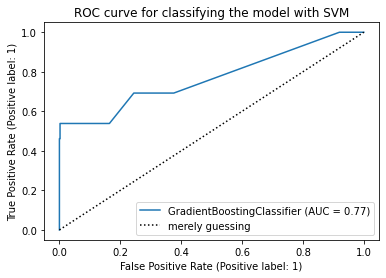

In [15]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,max_depth=1, random_state=0)
clf.fit(X_train, y_train)

probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
accuracy = clf.score(X_test, y_test)
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)
print(f'Accuracy on test data is {accuracy:.3}')
print(f'Area under ROC curve on test data is {auc:.3}.')

y_hat = clf.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
precision = precision_score(y_true=y_test, y_pred=y_hat)
recall = recall_score(y_true=y_test, y_pred=y_hat)
print(f'precision={precision:.3}, recall={recall:.3}, accuracy={accuracy:.3}')

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying the model with SVM')
plt.legend()
plt.show(block=False)

Note the high accuracy but lousy precision, recall, and AUC.

Note that since the data have about 98% $y = 0$, we could get about 98% accuracy
by just always predicting $\hat{y} = 0$. High accuracy alone is not necessarily helpful.

### 3b. Now oversample the data to get a balanced data set.
- Use the `RandomOverSampler(random_state=0)` to oversample and get a balanced data set.
- Repeat my `train_test_split()` block from above.
- Repeat your train/assess block from above.

Accuracy on test data is 0.957
Area under ROC curve on test data is 0.993.
precision=0.97, recall=0.942, accuracy=0.957


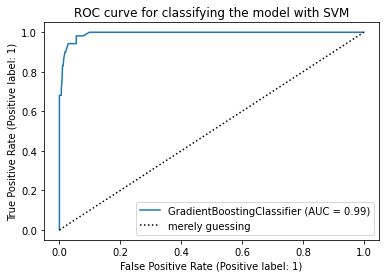

In [16]:
rs = RandomOverSampler(random_state=0)
X_resampled, y_resampled = rs.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.5,
                                                    random_state=0, stratify=y_resampled)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,max_depth=1, random_state=0)
clf.fit(X_train, y_train)

probability_y_is_1 = clf.predict_proba(X_test)[:, 1]
accuracy = clf.score(X_test, y_test)
auc = roc_auc_score(y_true=y_test, y_score=probability_y_is_1)
print(f'Accuracy on test data is {accuracy:.3}')
print(f'Area under ROC curve on test data is {auc:.3}.')

y_hat = clf.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_hat)
precision = precision_score(y_true=y_test, y_pred=y_hat)
recall = recall_score(y_true=y_test, y_pred=y_hat)
print(f'precision={precision:.3}, recall={recall:.3}, accuracy={accuracy:.3}')

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifying the model with SVM')
plt.legend()
plt.show(block=False)

Note that we traded a little accuracy for much improved precision, recall, and AUC.

If you do classification in your project and report accuracy, please
also report the proportions of $y = 0$ and $y = 1$ in your test data so that
we get insight into whether your model improves upon always guessing $\hat{y} = 0$
or always guessing $\hat{y} = 1$.